In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import locationtagger
from geotext import GeoText
from textblob import TextBlob
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#importing scrapped dataset
air = pd.read_csv('AirCanada_review_raw.csv')

In [3]:
#dropping index and page colums
air = air.drop(axis=1, columns=['Unnamed: 0','page'])

#replacing null values with blanks
air.fillna("", inplace = True)

In [4]:
#getting list of cities mentioned in column - 'Route'
def get_cities(text):
    if len(text)==0:
        return []
    places = GeoText(text)
    return places.cities

air['cities'] = air['Route'].apply(get_cities)

In [5]:
#getting an unique list of cities mentioned in all reviews
city = []

def unique_cities(cities):
    for a in cities:
        if a.lower() not in city:
            city.append(a.lower())
            
air['cities'].apply(unique_cities)

0       None
1       None
2       None
3       None
4       None
        ... 
1639    None
1640    None
1641    None
1642    None
1643    None
Name: cities, Length: 1644, dtype: object

In [6]:
#Getting the average ratings based on multiple parameter ratings in datset
#please note that here we only consider the ratings which are greater than zero with the assumption that zero ratings are not admissible.
air['sum_ratings'] = air.where(air[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']] > 0).sum(1)
air['count_ratings'] = air.where(air[['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Wifi & Connectivity', 'Value For Money']] > 0).count(1)
air['avg_rating'] = air['sum_ratings']/air['count_ratings']

### Using of TextBlob library for sentiment analysis

- Using TextBlob library to get the sentiment of text provided.
- The TextBlob functions returns a tuple -> (sentiment, subjectivity).
    - Sentiment values can range from -1(extreme negative) to +1(extreme positive).
    - Subjectivity values ranges from 0(pretty generic) to 1(highly subjective).

In [7]:
#Using TextBlob library, getting sentiment values on column - Title and Reviews
def get_blob(lemma):
    return TextBlob(lemma).sentiment[0]

air['title_blob'] = air['title'].apply(get_blob)
air['review_blob'] = air['review'].apply(get_blob)

In [8]:
#getting common stopwords from NLTK and building a list of some noted stopwords recognized in text.
stop_words = stopwords.words('english')
newStopWords = ['air', 'canada', 'even', 'also', 'us', 'would', 'could', 'get', 'got', 'go', 'flight', 'flights', 'said', 'next', 'one', 'two', 'made', 'however', 'went', 'without', 'say', 'said', 'montreal', 'february', 'since', 'prior', 'another', 'airline']

In [9]:
#tokenizing text and clearing off stopwords
wl = WordNetLemmatizer()

def get_tokens(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in stop_words and word.isalpha() and word.lower() not in city and word.lower() not in newStopWords:
            newlist.append(wl.lemmatize(word.lower()))
    return newlist

In [10]:
#adding columns with tokens for reviews and title
air['review_tokens'] = air['review'].apply(get_tokens)
air['title_tokens'] = air['title'].apply(get_tokens)

Below we define a function to build word frequency. Based on sentiment values assigned by TextBlob library, we pass the reviews and titles with blob values above zero as positive lists and below zero as negative list to the frquency builder function. This function then returns a dictionary of words and its frequency in all of the data along with its context.
For example, if 'service' is repeated 200 times in reviews marked as positive and 100 times in reviews marked as negative, then two dictionary entries would be added. One to note the positive context of the word with key -> ('service', 1) and values as 200. Then to note the frequency in negative context, another entry with key -> ('service', 0) will be added next to the frequency value of 100.

In [11]:
def build_word_freq(pos_list, neg_list):
    freq_dict={}
    for token_list in pos_list:
        for token in token_list:
            if (token, 1) not in freq_dict.keys():
                freq_dict[(token, 1)] = 1
            else:
                freq_dict[(token, 1)] = freq_dict[(token, 1)] + 1
    for token_list in neg_list:
        for token in token_list:
            if (token, 0) not in freq_dict.keys():
                freq_dict[(token, 0)] = 1
            else:
                freq_dict[(token, 0)] = freq_dict[(token, 0)] + 1  
    return freq_dict

### Creating frequency dictionary based on sentiment values from TextBlob library

In [12]:
#building frequency dictionary for each token with a particular label
frequency_dict_review = build_word_freq(air.loc[air['review_blob'] > 0, 'review_tokens'].tolist(), air.loc[air['review_blob'] < 0, 'review_tokens'].tolist())
frequency_dict_title = build_word_freq(air.loc[air['title_blob'] > 0, 'title_tokens'].tolist(), air.loc[air['title_blob'] < 0, 'title_tokens'].tolist())

In [13]:
#displaying sorted list for word frequency in reviews column
sorted(frequency_dict_review.items(),key=itemgetter(1), reverse = True)

[(('seat', 1), 1004),
 (('service', 1), 832),
 (('time', 1), 826),
 (('hour', 1), 642),
 (('good', 1), 574),
 (('food', 1), 461),
 (('plane', 1), 444),
 (('hour', 0), 444),
 (('ac', 1), 426),
 (('staff', 1), 419),
 (('crew', 1), 400),
 (('seat', 0), 388),
 (('service', 0), 365),
 (('passenger', 1), 339),
 (('time', 0), 338),
 (('class', 1), 335),
 (('cabin', 1), 332),
 (('airport', 1), 331),
 (('economy', 1), 330),
 (('fly', 1), 330),
 (('told', 1), 327),
 (('back', 1), 326),
 (('day', 1), 315),
 (('bag', 1), 314),
 (('business', 1), 300),
 (('attendant', 1), 299),
 (('meal', 1), 297),
 (('customer', 1), 294),
 (('experience', 1), 292),
 (('first', 1), 286),
 (('boarding', 1), 277),
 (('luggage', 1), 261),
 (('plane', 0), 261),
 (('new', 1), 255),
 (('delayed', 1), 252),
 (('gate', 1), 248),
 (('staff', 0), 244),
 (('great', 1), 242),
 (('customer', 0), 237),
 (('agent', 1), 235),
 (('minute', 1), 235),
 (('way', 1), 233),
 (('entertainment', 1), 231),
 (('trip', 1), 223),
 (('check', 

In [14]:
#Segregating frequency dictionary of review column based on positive or negative context.
pos_review = []
neg_review = []
for k, v in frequency_dict_review:
    if v == 1:
        pos_review.append((k,frequency_dict_review[(k,v)]))
    else:
        neg_review.append((k,frequency_dict_review[(k,v)]))

In [15]:
#displaying sorted list for word frequency in reviews column used in negative context.
sorted(neg_review,key=itemgetter(1), reverse = True)

[('hour', 444),
 ('seat', 388),
 ('service', 365),
 ('time', 338),
 ('plane', 261),
 ('staff', 244),
 ('customer', 237),
 ('airport', 201),
 ('food', 198),
 ('passenger', 196),
 ('day', 183),
 ('told', 182),
 ('delayed', 165),
 ('back', 160),
 ('bag', 148),
 ('never', 142),
 ('minute', 139),
 ('meal', 139),
 ('experience', 137),
 ('gate', 135),
 ('due', 133),
 ('ac', 126),
 ('luggage', 114),
 ('fly', 110),
 ('late', 109),
 ('boarding', 108),
 ('via', 107),
 ('worst', 107),
 ('business', 107),
 ('crew', 107),
 ('baggage', 106),
 ('asked', 105),
 ('trip', 104),
 ('ticket', 103),
 ('hotel', 101),
 ('delay', 101),
 ('class', 99),
 ('return', 99),
 ('rude', 95),
 ('way', 95),
 ('attendant', 95),
 ('arrived', 94),
 ('take', 92),
 ('still', 90),
 ('economy', 89),
 ('people', 89),
 ('long', 89),
 ('issue', 88),
 ('later', 87),
 ('line', 85),
 ('change', 84),
 ('flying', 82),
 ('cabin', 81),
 ('first', 81),
 ('new', 80),
 ('agent', 80),
 ('call', 80),
 ('cancelled', 79),
 ('last', 79),
 ('poor'

In [16]:
#displaying sorted list for word frequency in title column
sorted(frequency_dict_title.items(),key=itemgetter(1), reverse = True)

[(('service', 0), 54),
 (('good', 1), 50),
 (('service', 1), 50),
 (('experience', 1), 34),
 (('customer', 0), 30),
 (('experience', 0), 29),
 (('seat', 0), 28),
 (('friendly', 1), 26),
 (('worst', 0), 26),
 (('crew', 1), 24),
 (('staff', 1), 22),
 (('cabin', 1), 22),
 (('terrible', 0), 22),
 (('great', 1), 20),
 (('excellent', 1), 18),
 (('poor', 0), 17),
 (('professional', 1), 14),
 (('pleasant', 1), 14),
 (('attentive', 1), 13),
 (('uncomfortable', 0), 13),
 (('seat', 1), 12),
 (('comfortable', 1), 12),
 (('best', 1), 11),
 (('rude', 0), 11),
 (('disappointed', 0), 11),
 (('fly', 1), 10),
 (('late', 0), 10),
 (('food', 0), 10),
 (('food', 1), 9),
 (('helpful', 1), 9),
 (('horrible', 0), 9),
 (('staff', 0), 9),
 (('extremely', 0), 9),
 (('bad', 0), 8),
 (('due', 0), 8),
 (('overall', 1), 7),
 (('new', 1), 7),
 (('enjoyable', 1), 7),
 (('attendant', 1), 7),
 (('absolutely', 0), 7),
 (('tight', 0), 7),
 (('customer', 1), 6),
 (('really', 1), 6),
 (('pretty', 1), 6),
 (('polite', 1), 6)

In [17]:
#Segregating frequency dictionary of title column based on positive or negative context.
pos_title = []
neg_title = []
for k, v in frequency_dict_title:
    if v == 1:
        pos_title.append((k,frequency_dict_title[(k,v)]))
    else:
        neg_title.append((k,frequency_dict_title[(k,v)]))

In [18]:
#displaying sorted list for word frequency in title column used in negative context.
sorted(neg_title,key=itemgetter(1), reverse = True)

[('service', 54),
 ('customer', 30),
 ('experience', 29),
 ('seat', 28),
 ('worst', 26),
 ('terrible', 22),
 ('poor', 17),
 ('uncomfortable', 13),
 ('rude', 11),
 ('disappointed', 11),
 ('late', 10),
 ('food', 10),
 ('horrible', 9),
 ('staff', 9),
 ('extremely', 9),
 ('bad', 8),
 ('due', 8),
 ('absolutely', 7),
 ('tight', 7),
 ('awful', 6),
 ('weather', 6),
 ('never', 5),
 ('average', 5),
 ('hard', 5),
 ('limited', 5),
 ('cancelled', 5),
 ('ground', 5),
 ('disappointment', 5),
 ('poorly', 5),
 ('hour', 5),
 ('appalling', 5),
 ('ever', 4),
 ('frustrating', 4),
 ('business', 4),
 ('class', 4),
 ('cold', 4),
 ('far', 4),
 ('space', 4),
 ('fly', 4),
 ('incompetent', 4),
 ('really', 4),
 ('cabin', 3),
 ('wrong', 3),
 ('attendant', 3),
 ('unpleasant', 3),
 ('check', 3),
 ('missing', 3),
 ('luggage', 3),
 ('delayed', 3),
 ('bag', 3),
 ('money', 3),
 ('narrow', 3),
 ('worth', 3),
 ('overall', 3),
 ('disappointing', 3),
 ('helpful', 3),
 ('delay', 3),
 ('least', 2),
 ('organization', 2),
 ('dis

### Creating frequency dictionary based on avg ratings

- Based on average ratings calculated above, creating a new word frequency dictionary.
- Here, average ratings < 3 are considered as reviews in negative context and ratings >= 3 are considered in positive context while passing to the frequency builder function.

In [19]:
#building frequency dictionary for each token with a particular label
freq_dict_review_avg = build_word_freq(air.loc[air['avg_rating'] >= 3, 'review_tokens'].tolist(), air.loc[air['avg_rating'] < 3, 'review_tokens'].tolist())
freq_dict_title_avg = build_word_freq(air.loc[air['avg_rating'] >= 3, 'title_tokens'].tolist(), air.loc[air['avg_rating'] < 3, 'title_tokens'].tolist())

In [20]:
#segregating word frequencies for reviews into list of words based on context.
avg_pos_review = []
avg_neg_review = []
for k, v in freq_dict_review_avg:
    if v == 1:
        avg_pos_review.append((k,freq_dict_review_avg[(k,v)]))
    else:
        avg_neg_review.append((k,freq_dict_review_avg[(k,v)]))

In [21]:
#segregating word frequencies for title into list of words based on context.
avg_pos_title = []
avg_neg_title = []
for k, v in freq_dict_title_avg:
    if v == 1:
        avg_pos_title.append((k,freq_dict_title_avg[(k,v)]))
    else:
        avg_neg_title.append((k,freq_dict_title_avg[(k,v)]))

In [22]:
#displaying words appearing in negative reviews based on average ratings.
sorted(avg_neg_review,key=itemgetter(1), reverse = True)

[('hour', 907),
 ('seat', 846),
 ('time', 774),
 ('service', 712),
 ('plane', 528),
 ('told', 470),
 ('customer', 466),
 ('day', 427),
 ('airport', 415),
 ('staff', 410),
 ('passenger', 381),
 ('bag', 377),
 ('delayed', 359),
 ('back', 337),
 ('food', 332),
 ('fly', 328),
 ('luggage', 307),
 ('gate', 295),
 ('minute', 294),
 ('ac', 292),
 ('never', 273),
 ('ticket', 251),
 ('due', 250),
 ('experience', 244),
 ('way', 242),
 ('attendant', 238),
 ('agent', 236),
 ('boarding', 235),
 ('first', 235),
 ('crew', 232),
 ('meal', 225),
 ('asked', 223),
 ('business', 221),
 ('delay', 217),
 ('via', 215),
 ('class', 212),
 ('arrived', 209),
 ('baggage', 208),
 ('people', 206),
 ('economy', 206),
 ('trip', 206),
 ('late', 203),
 ('take', 202),
 ('check', 201),
 ('hotel', 198),
 ('new', 197),
 ('cancelled', 193),
 ('last', 191),
 ('later', 188),
 ('return', 188),
 ('booked', 186),
 ('make', 183),
 ('waiting', 182),
 ('line', 182),
 ('issue', 176),
 ('call', 176),
 ('still', 173),
 ('connection', 1

### Plotting bar graphs for word frequencies based on above calculations

#### 1. Bar graphs for top 10 most frequented words based on average ratings

In [23]:
df1 = pd.DataFrame(avg_neg_review, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df2 = pd.DataFrame(avg_pos_review, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df3 = pd.DataFrame(avg_neg_title, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df4 = pd.DataFrame(avg_pos_title, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)

In [24]:
sorted(avg_pos_review,key=itemgetter(1), reverse = True)

[('seat', 549),
 ('service', 488),
 ('good', 462),
 ('time', 392),
 ('food', 328),
 ('crew', 277),
 ('ac', 263),
 ('staff', 257),
 ('cabin', 250),
 ('class', 225),
 ('economy', 215),
 ('meal', 214),
 ('great', 201),
 ('hour', 191),
 ('business', 189),
 ('experience', 186),
 ('plane', 181),
 ('comfortable', 169),
 ('friendly', 166),
 ('passenger', 157),
 ('attendant', 156),
 ('back', 152),
 ('boarding', 150),
 ('excellent', 143),
 ('flew', 141),
 ('new', 138),
 ('entertainment', 138),
 ('aircraft', 137),
 ('well', 135),
 ('first', 133),
 ('really', 124),
 ('trip', 123),
 ('drink', 123),
 ('airport', 121),
 ('better', 121),
 ('long', 116),
 ('fly', 114),
 ('return', 111),
 ('leg', 111),
 ('much', 110),
 ('choice', 108),
 ('overall', 106),
 ('nice', 104),
 ('selection', 103),
 ('flying', 102),
 ('check', 99),
 ('like', 98),
 ('lounge', 96),
 ('airline', 93),
 ('system', 93),
 ('quite', 92),
 ('arrived', 91),
 ('gate', 90),
 ('way', 89),
 ('ife', 89),
 ('bag', 87),
 ('via', 87),
 ('left', 

<Figure size 1080x720 with 0 Axes>

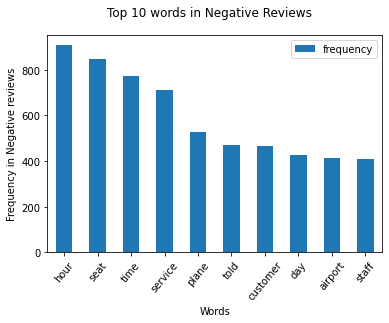

In [25]:
plt.figure(figsize=(15,10))
df1[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Negative reviews")
plt.suptitle("Top 10 words in Negative Reviews")
plt.show()

<Figure size 1080x720 with 0 Axes>

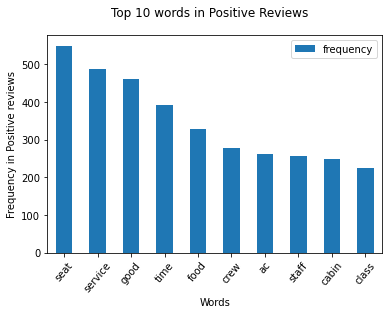

In [26]:
plt.figure(figsize=(15,10))
df2[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Positive reviews")
plt.suptitle("Top 10 words in Positive Reviews")
plt.show()

<Figure size 1080x720 with 0 Axes>

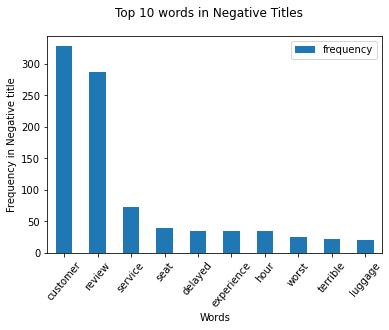

In [27]:
plt.figure(figsize=(15,10))
df3[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Negative title")
plt.suptitle("Top 10 words in Negative Titles")
plt.show()

<Figure size 1080x720 with 0 Axes>

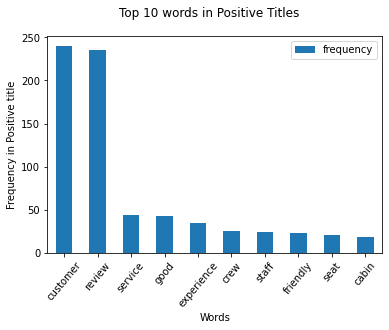

In [28]:
plt.figure(figsize=(15,10))
df4[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Positive title")
plt.suptitle("Top 10 words in Positive Titles")
plt.show()

#### 2. Bar graphs for top 10 most frequented words based on sentiment values

In [29]:
df5 = pd.DataFrame(neg_review, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df6 = pd.DataFrame(pos_review, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df7 = pd.DataFrame(neg_title, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df8 = pd.DataFrame(pos_title, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)

<Figure size 1080x720 with 0 Axes>

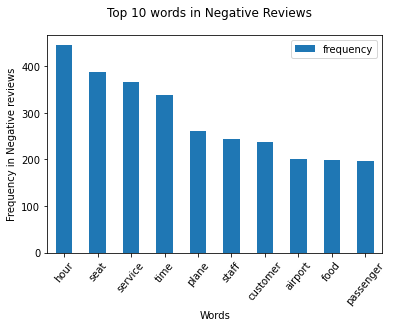

In [30]:
plt.figure(figsize=(15,10))
df5[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Negative reviews")
plt.suptitle("Top 10 words in Negative Reviews")
plt.show()

<Figure size 1080x720 with 0 Axes>

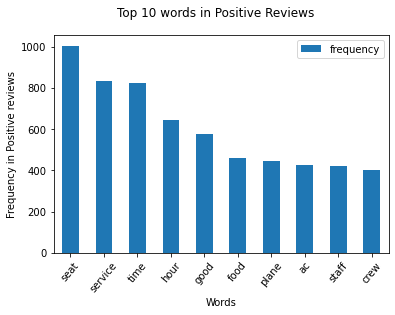

In [31]:
plt.figure(figsize=(15,10))
df6[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Positive reviews")
plt.suptitle("Top 10 words in Positive Reviews")
plt.show()

<Figure size 1080x720 with 0 Axes>

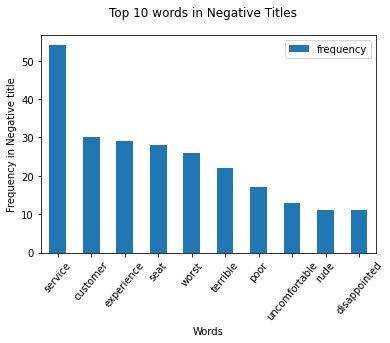

In [32]:
plt.figure(figsize=(15,10))
df7[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Negative title")
plt.suptitle("Top 10 words in Negative Titles")
plt.show()

<Figure size 1080x720 with 0 Axes>

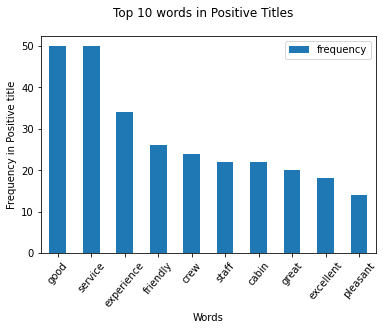

In [33]:
plt.figure(figsize=(15,10))
df8[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Positive title")
plt.suptitle("Top 10 words in Positive Titles")
plt.show()

### Concatenting Reviews and Title for Frequency Dictionary

Combining list of tokens from reviews and title columns before building word frequencies.

In [34]:
pos_rev_title = air.loc[air['review_blob'] > 0, 'review_tokens'].tolist()

In [35]:
pos_rev_title.extend(air.loc[air['title_blob'] > 0, 'title_tokens'].tolist())

In [36]:
len(pos_rev_title)

1423

In [37]:
neg_rev_title = air.loc[air['review_blob'] < 0, 'review_tokens'].tolist()
neg_rev_title.extend(air.loc[air['title_blob'] < 0, 'title_tokens'].tolist())

In [38]:
len(neg_rev_title)

845

In [39]:
#building frequency dictionary for each token with a particular label
freq_dict_combined = build_word_freq(pos_rev_title, neg_rev_title)

In [40]:
avg_pos = []
avg_neg = []
for k, v in freq_dict_combined:
    if v == 1:
        avg_pos.append((k,freq_dict_combined[(k,v)]))
    else:
        avg_neg.append((k,freq_dict_combined[(k,v)]))

In [41]:
df9 = pd.DataFrame(avg_pos, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)
df10 = pd.DataFrame(avg_neg, columns=['words', 'frequency']).sort_values(by=['frequency'], ascending=False)

<Figure size 1080x720 with 0 Axes>

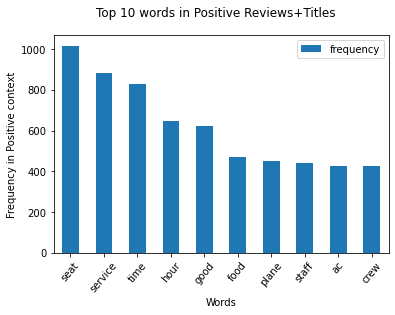

In [42]:
plt.figure(figsize=(15,10))
df9[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Positive context")
plt.suptitle("Top 10 words in Positive Reviews+Titles")
plt.show()

<Figure size 1080x720 with 0 Axes>

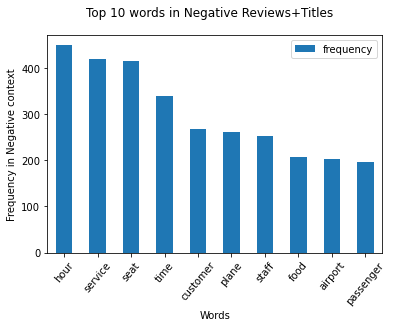

In [43]:
plt.figure(figsize=(15,10))
df10[:10].sort_values(by='frequency', ascending=False).plot.bar(x='words')
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequency in Negative context")
plt.suptitle("Top 10 words in Negative Reviews+Titles")
plt.show()

### Plotting some parameters based on sentiments

In [44]:
#Classifying reviews into two categories, positve or negative, based on their sentiment values
air.loc[air['review_blob'] > 0, 'review_sent'] = 'pos'
air.loc[air['review_blob'] < 0, 'review_sent'] = 'neg'

<AxesSubplot:xlabel='Seat Comfort', ylabel='Count'>

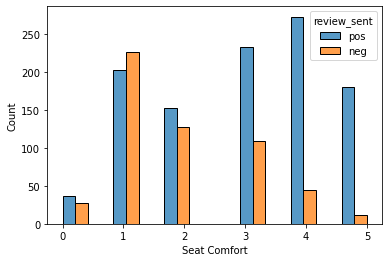

In [45]:
sns.histplot(data=air, x="Seat Comfort", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Food & Beverages', ylabel='Count'>

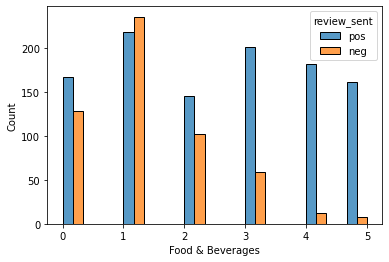

In [46]:
sns.histplot(data=air, x="Food & Beverages", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Cabin Staff Service', ylabel='Count'>

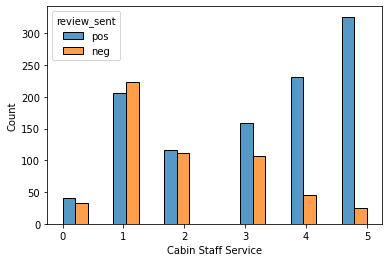

In [47]:
sns.histplot(data=air, x="Cabin Staff Service", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Wifi & Connectivity', ylabel='Count'>

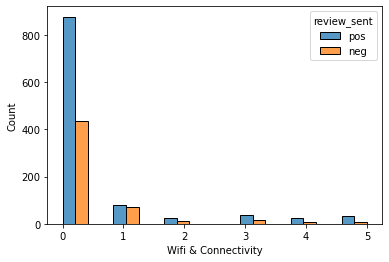

In [48]:
sns.histplot(data=air, x="Wifi & Connectivity", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Ground Service', ylabel='Count'>

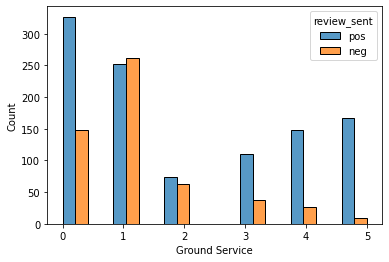

In [50]:
sns.histplot(data=air, x="Ground Service", hue="review_sent", multiple="dodge")

<AxesSubplot:xlabel='Seat Type', ylabel='Count'>

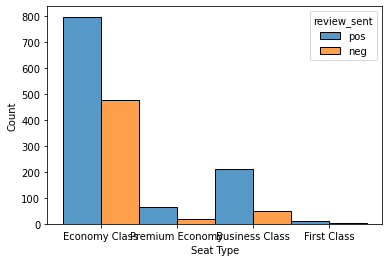

In [51]:
sns.histplot(data=air, x="Seat Type", hue="review_sent", multiple="dodge")